In [1]:
try:
    import google.colab  # noqa: F401

    %pip install -q dataeval
except Exception:
    pass

import os

from pytest import approx

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import torchvision.transforms.v2 as v2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer
from tensorflow.nn import relu
from torchvision.datasets import MNIST

from dataeval.metrics import BER

tf.keras.utils.set_random_seed(408)

In [3]:
# Load in both the training and testing mnist dataset
train_ds = MNIST(root="./data/", train=True, download=True, transform=v2.ToImage())
test_ds = MNIST(root="./data/", train=False, download=True, transform=v2.ToImage())

# Split out the images and labels for each set
images, labels = train_ds.data.numpy(), train_ds.targets.numpy()
test_images, test_labels = test_ds.data.numpy(), test_ds.targets.numpy()

In [4]:
print("Number of training samples: ", len(images))
print("Image shape:", images[0].shape)
print("Label counts: ", np.unique(labels, return_counts=True))

Number of training samples:  60000
Image shape: (28, 28)
Label counts:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


In [5]:
images_split = {}
labels_split = {}

# Keep only 1, 4, and 9
for label in (1, 4, 9):
    subset_indices = np.where(labels == label)
    images_split[label] = images[subset_indices][:2000]
    labels_split[label] = labels[subset_indices][:2000]

images_subset = np.concatenate(list(images_split.values()))
labels_subset = np.concatenate(list(labels_split.values()))
print(images_subset.shape)
print(np.unique(labels_subset, return_counts=True))

(6000, 28, 28)
(array([1, 4, 9]), array([2000, 2000, 2000]))


In [6]:
# Flatten the images
images_flattened = images_subset.reshape((images_subset.shape[0], -1))
print("Dataset shape:", images_flattened.shape)

Dataset shape: (6000, 784)


In [7]:
# Load the BER metric
metric = BER(method="MST")

In [8]:
# Evaluate the BER metric for the MNIST data with digits 1, 4, 9.
# One minus the value of this metric gives our estimate of the upper bound on accuracy.
base_ber = metric.evaluate(images_flattened, labels_subset)

In [9]:
print("The bayes error rate estimation:", base_ber)

The bayes error rate estimation: {'ber': 0.025833333333333333, 'ber_lower': 0.013044281629080704}


In [10]:
### TEST ASSERTION ###
print(base_ber)
assert base_ber["ber"] == approx(0.025833, abs=1e-6)
assert base_ber["ber_lower"] == approx(0.0130443, abs=1e-6)

{'ber': 0.025833333333333333, 'ber_lower': 0.013044281629080704}


In [11]:
print("The maximum achievable accuracy:", (1 - base_ber["ber"]) * 100)

The maximum achievable accuracy: 97.41666666666666


In [12]:
# Creates a binary mask where current label == 1 that can be used as the new labels
labels_merged = labels_subset == 1
print("New label counts:", np.unique(labels_merged, return_counts=True))

New label counts: (array([False,  True]), array([4000, 2000]))


In [13]:
# Evaluate the BER metric for the MNIST data with updated labels
new_ber = metric.evaluate(images_flattened, labels_merged)

In [14]:
print("The bayes error rate estimation:", new_ber)

The bayes error rate estimation: {'ber': 0.005, 'ber_lower': 0.0025062814466900174}


In [15]:
### TEST ASSERTION ###
print(new_ber)
assert new_ber["ber"] == approx(0.005, abs=1e-6)
assert new_ber["ber_lower"] == approx(0.002506, abs=1e-6)

{'ber': 0.005, 'ber_lower': 0.0025062814466900174}


In [16]:
print("The maximum achievable accuracy:", 1 - new_ber["ber"])

The maximum achievable accuracy: 0.995


In [17]:
# Build a simple CNN for classifying MNIST images.
model = Sequential(
    [
        InputLayer(input_shape=(28, 28, 1)),
        Conv2D(
            64,
            4,
            strides=2,
            padding="same",
            activation=relu,
        ),
        Conv2D(
            128,
            4,
            strides=2,
            padding="same",
            activation=relu,
        ),
        Conv2D(
            512,
            4,
            strides=2,
            padding="same",
            activation=relu,
        ),
        Flatten(),
        Dense(2),
    ]
)

In [18]:
test_indices = np.where((test_labels == 1) | (test_labels == 4) | (test_labels == 9))
test_images_subset = test_images[test_indices]
test_labels_subset = test_labels[test_indices]
test_labels_merged = test_labels_subset == 1

In [19]:
# Set up model hyperparameters
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Fitting a model may take a few minutes
history = model.fit(
    images_subset,
    labels_merged,
    epochs=90,
    batch_size=32,
    steps_per_epoch=1,
    validation_data=(test_images_subset, test_labels_merged),
    verbose=0,
)

In [20]:
loss, accuracy = model.evaluate(test_images_subset, test_labels_merged, verbose=1)
print(f"The model accuracy: {accuracy*100:0.2f}%")

 1/98 [..............................] - ETA: 2s - loss: 0.0157 - accuracy: 1.0000

 8/98 [=>............................] - ETA: 0s - loss: 0.0500 - accuracy: 0.9844

15/98 [===>..........................] - ETA: 0s - loss: 0.0361 - accuracy: 0.9875

21/98 [=====>........................] - ETA: 0s - loss: 0.0332 - accuracy: 0.9896

27/98 [=======>......................] - ETA: 0s - loss: 0.0479 - accuracy: 0.9850

33/98 [=========>....................] - ETA: 0s - loss: 0.0478 - accuracy: 0.9830

40/98 [===========>..................] - ETA: 0s - loss: 0.0414 - accuracy: 0.9852

47/98 [=============>................] - ETA: 0s - loss: 0.0396 - accuracy: 0.9867

53/98 [===============>..............] - ETA: 0s - loss: 0.0390 - accuracy: 0.9876

61/98 [=================>............] - ETA: 0s - loss: 0.0364 - accuracy: 0.9887

67/98 [===================>..........] - ETA: 0s - loss: 0.0377 - accuracy: 0.9888

75/98 [=====================>........] - ETA: 0s - loss: 0.0345 - accuracy: 0.9900

80/98 [=======================>......] - ETA: 0s - loss: 0.0330 - accuracy: 0.9902

87/98 [=========================>....] - ETA: 0s - loss: 0.0305 - accuracy: 0.9910

95/98 [============================>.] - ETA: 0s - loss: 0.0286 - accuracy: 0.9918

98/98 [==============================] - 1s 8ms/step - loss: 0.0295 - accuracy: 0.9914


The model accuracy: 99.14%


In [21]:
### TEST ASSERTION ###
print(accuracy)
assert accuracy == approx(0.9914, abs=1e-4)

0.9913627505302429


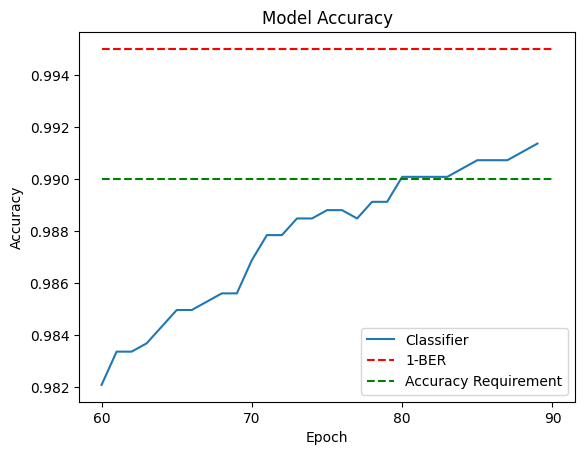

In [22]:
plt.title("Model Accuracy")
plt.plot(range(60, 90), np.array(history.history["val_accuracy"])[60:], label="Classifier")
plt.hlines(
    y=1 - new_ber["ber"],
    colors=["red"],
    xmin=60,
    xmax=90,
    label="1-BER",
    linestyles="dashed",
)
plt.hlines(
    y=0.99,
    colors=["green"],
    xmin=60,
    xmax=90,
    label="Accuracy Requirement",
    linestyles="dashed",
)

plt.xticks(range(60, 91, 10))
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc=4)